Following [a simple but efficient real-time voice activity detection
algorithm](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2009/contents/papers/1569192958.pdf).

In [18]:
import math
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torchaudio

In [19]:
# Voice sound
dataset = torchaudio.datasets.YESNO("~/yesno")
waveform = dataset[0][0]
sample_rate = 8 * 10**3

# Train sound
# filename = "_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
# waveform, sample_rate = torchaudio.load(filename)

# Convert to mono    
waveform = waveform.mean(0).view(1,-1)

There are three criteria to decide if a frame contains speech: energy, most dominant frequency, and spectral flatness. If any two of those are higher than a minimum plus a threshold, then the frame contains speech. In the offline case, the list of frames is postprocessed to remove too short silence and speech sequences. In the online case here, inertia is added before switching from speech to silence or vice versa.

In [20]:
def compute_spectral_flatness(frame):
    EPSILON = 0.01
    n = frame.nonzero().size(0)
    geometric_mean = torch.exp((EPSILON + frame).log().mean(-1)) - EPSILON
    arithmetic_mean = frame.mean(-1)
    return -10 * torch.log10(EPSILON + geometric_mean/arithmetic_mean)

def compute_energy(frame):
    return frame.pow(2).sum(-1)


class VoiceActivityDetection(object):

    def __init__(self):

        self.num_init_frames = 30
        self.ignore_silent_count = 10
        self.ignore_speech_count = 5

        self.energy_prim_thresh = 40
        self.frequency_prim_thresh = 5
        self.spectral_flatness_prim_thresh = 3
        
        self.ignore_silent_count = 4
        self.ignore_speech_count = 1

        self.speech_mark = True
        self.silence_mark = False

        self.silent_count = 0
        self.speech_count = 0
        self.n = 0
        
        self.energy_list = []
        self.frequency_list = []
        self.spectral_flatness_list = []

    def iter(self, frame):

        EPSILON = 1.
        frame_fft = torch.rfft(frame, 1)
        amplitudes = torchaudio.functional.complex_norm(frame_fft)

        # Compute frame energy
        energy = compute_energy(frame)
    
        # Most dominant frequency component
        frequency = amplitudes.argmax()
    
        # Spectral flatness measure
        spectral_flatness = compute_spectral_flatness(amplitudes)
        
        self.energy_list.append(energy)
        self.frequency_list.append(frequency)
        self.spectral_flatness_list.append(spectral_flatness)
    
        if self.n == 0:
            self.min_energy = energy
            self.min_frequency = frequency
            self.min_spectral_flatness = spectral_flatness
        elif self.n < self.num_init_frames:
            self.min_energy = min(energy, self.min_energy)
            self.min_frequency = min(frequency, self.min_frequency)
            self.min_spectral_flatness = min(spectral_flatness, self.min_spectral_flatness)
    
        self.n +=1
        
        thresh_energy = self.energy_prim_thresh * torch.log(EPSILON + self.min_energy)
        thresh_frequency = self.frequency_prim_thresh
        thresh_spectral_flatness = self.spectral_flatness_prim_thresh
    
        # Check all three conditions
    
        counter = 0
        if energy - self.min_energy >= thresh_energy:
            counter += 1
        if frequency - self.min_frequency >= thresh_frequency: 
            counter += 1
        if spectral_flatness - self.min_spectral_flatness >= thresh_spectral_flatness: 
            counter += 1
        
        # Detection
        if counter > 1:
            # Speech detected
            self.speech_count += 1
            # Inertia against switching
            if self.n >= self.num_init_frames and self.speech_count <= self.ignore_speech_count:
                # Too soon to change
                return self.silence_mark
            else:
                self.silent_count = 0
                return self.speech_mark
        else:
            # Silence detected
            self.min_energy = ((self.silent_count * self.min_energy) + energy) / (self.silent_count + 1)
            self.silent_count += 1
            # Inertia against switching
            if self.n >= self.num_init_frames and self.silent_count <= self.ignore_silent_count:
                # Too soon to change
                return self.speech_mark
            else:
                self.speech_count = 0
                return self.silence_mark

In [21]:
def reconstruct_waveform(speech_frames, waveform):
    z = torch.zeros(waveform.shape, dtype=waveform.dtype, device=waveform.device)

    # Convert to waveform
    n_frames = len(speech_frames)
    for i in range(n_frames):
        z[0, i*frame_size:(i+1)*frame_size] = int(speech_frames[i])
    
    # Extend with what was last detected
    z[0, n_frames*frame_size:-1] = int(speech_frames[-1])
    return z

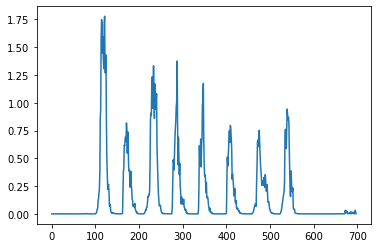

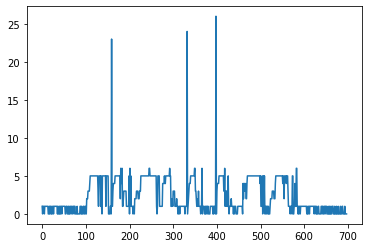

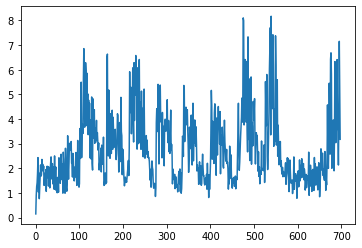

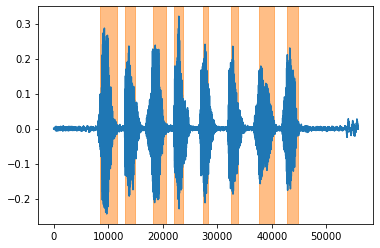

In [46]:
# Determine number of frames and frame size

frame_time = 10**-2

frame_size = int(math.ceil(sample_rate*frame_time))
waveform_length = waveform.size()[-1]
num_of_frames = math.floor(waveform_length/frame_size)

# Iterate VAD

vad = VoiceActivityDetection()
speech_frames = []

for n in range(num_of_frames):
    waveform_short = waveform[0, n*frame_size:(n+1)*frame_size]
    speech_frames.append(vad.iter(waveform_short))

z = reconstruct_waveform(speech_frames, waveform)


plt.figure()
plt.plot(vad.energy_list)
plt.figure()
plt.plot(vad.frequency_list)
plt.figure()
plt.plot(vad.spectral_flatness_list)


plt.figure()
plt.plot(waveform.t())
# plt.plot(waveform.abs().max()*z.t())

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

delta = (z[0, 1:] - z[0, :-1]).nonzero()
for a,b in zip(delta[0::2], delta[1::2]):
    plt.axvspan(a, b, alpha=0.5, color=colors[1])